# Set Up

## Imports

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import random
from PIL import Image

In [2]:
!pip install dlib
!pip install face_recognition

In [3]:
import face_recognition

## Image example

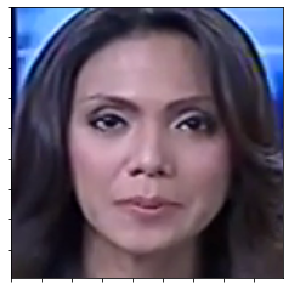

(224, 224, 3)


In [4]:
path = '0135.png'
test_img = cv2.imread(path)
test_img = np.array(test_img)
test_img = cv2.resize(test_img,(224,224))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR) # not necessary (changes colour output)

# show
fig, ax = plt.subplots(figsize = (5, 5))
plt.imshow(test_img);
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()
print(test_img.shape)

# GridMask

Implementation of GridMask for tensorflow, the code is taken exactly from https://www.kaggle.com/xiejialun/gridmask-data-augmentation-with-tensorflow/notebook

The main concept is that cutting out a grid of varying size is a better tool that cutting out squares randomly because statistically GridMask is more likely to cut out parts but not all of the image. More detail and evaluation of GridMask against two other cutout augmentation methods are in the original GridMask paper.

## Implementation

In [4]:
AugParams = {
    'd1' : int(224/5),
    'd2': int(224/2.5),
    'rotate' : 0,
    'ratio' : 0.5
}

def transform(image, inv_mat, image_shape):
    '''Used in random_rotate
    
    Taken from https://www.kaggle.com/xiejialun/gridmask-data-augmentation-with-tensorflow/notebook'''

    h, w, c = image_shape
    cx, cy = w//2, h//2

    new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
    new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
    new_zs = tf.ones([h*w], dtype=tf.int32)

    old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
    old_coords_x, old_coords_y = tf.round(old_coords[0, :] + w//2), tf.round(old_coords[1, :] + h//2)

    clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
    clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
    clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)

    old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
    old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
    new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
    new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))

    old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
    new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
    rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
    rotated_image_channel = list()
    for i in range(c):
        vals = rotated_image_values[:,i]
        sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
        rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))

    return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

def random_rotate(image, angle, image_shape):
    '''Used to rotate grid mask is requested in GridMask function
    
    Taken from https://www.kaggle.com/xiejialun/gridmask-data-augmentation-with-tensorflow/notebook'''

    def get_rotation_mat_inv(angle):
          #transform to radian
        angle = math.pi * angle / 180

        cos_val = tf.math.cos(angle)
        sin_val = tf.math.sin(angle)
        one = tf.constant([1], tf.float32)
        zero = tf.constant([0], tf.float32)

        rot_mat_inv = tf.concat([cos_val, sin_val, zero,
                                     -sin_val, cos_val, zero,
                                     zero, zero, one], axis=0)
        rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])

        return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform(image, rot_mat_inv, image_shape)


def GridMask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):
    '''Outputs a grid mask (based on image dimensions and other four parameters)
    which is later applied to an image
    
     Taken from https://www.kaggle.com/xiejialun/gridmask-data-augmentation-with-tensorflow/notebook'''

    h, w = image_height, image_width
    hh = int(np.ceil(np.sqrt(h*h+w*w)))
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges <0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges <0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

    return mask

def apply_GridMask(image, image_shape):
    '''Takes in an image and applies a grid mask to it (subject to parameters 
    which are specified externally)
    
     Taken from https://www.kaggle.com/xiejialun/gridmask-data-augmentation-with-tensorflow/notebook'''

    mask = GridMask(image_shape[0],
                    image_shape[1],
                    AugParams['d1'],
                    AugParams['d2'],
                    AugParams['rotate'],
                    AugParams['ratio'])
    
    if image_shape[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)

    return image * tf.cast(mask, tf.uint8)

In [5]:
def GridMask_augmentation(image, prob = 0.5):
    '''With probability prob (inputted value, by default 0.5),
    augments an inputted image with apply_GridMask
    
    Returns a (sometimes modified with grid mask) image'''
    if tf.random.uniform(shape=[], minval=0.0, maxval=1.0) <= prob:
        image = apply_GridMask(image, image.shape)
    return tf.cast(image, tf.uint8)

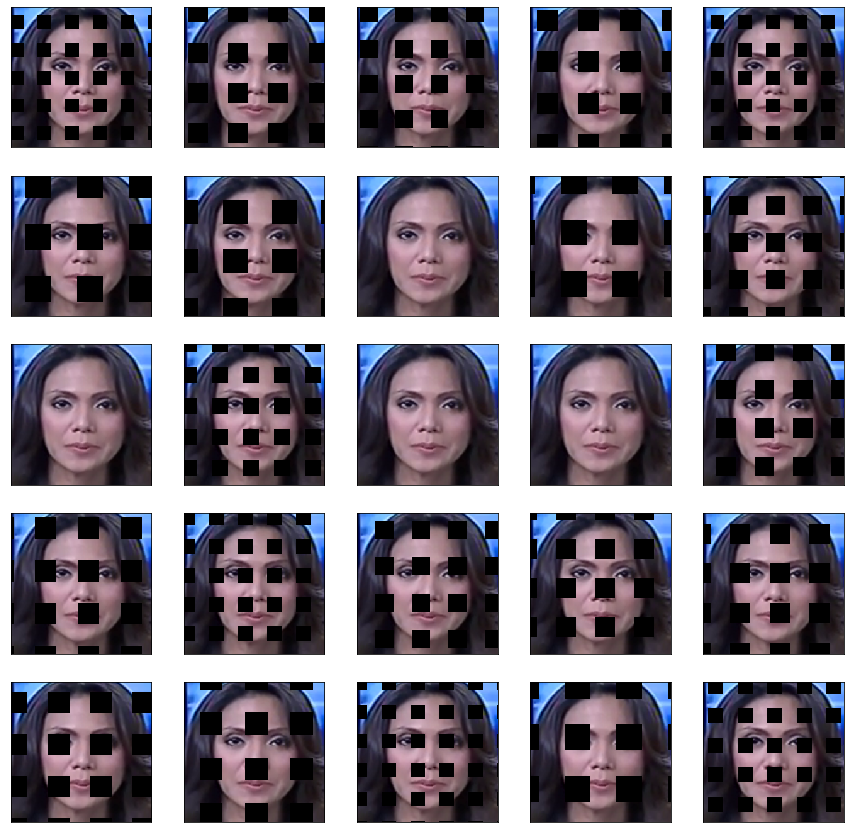

In [6]:
fig, axe = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        axe[i][j].imshow(GridMask_augmentation(test_img, 0.85), interpolation="nearest")
        axe[i][j].set_xticks([])
        axe[i][j].set_yticks([])

plt.show()

## Image for Report

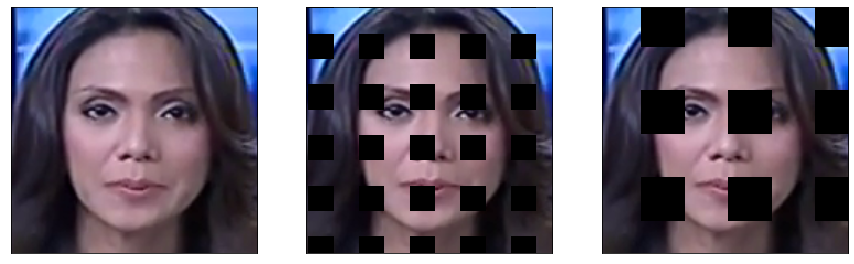

In [59]:
# FIGURE FOR THE REPORT TO ILLUSTRATE GRIDMASK AUGMENTATION

fig, axe = plt.subplots(1, 3, figsize = (15,5))
for i in range(3):
        axe[i].imshow(GridMask_augmentation(test_img, 0.85), interpolation="nearest")
        axe[i].set_xticks([])
        axe[i].set_yticks([])
plt.show()

# GridMask-Alternative

GridMask-alternative is implemented from scratch. The function simply cuts along the middle of both axis, without preforming and facial landmarks detection. The idea is based on the first-place solution for DFDC challenge, where it is shown that this time of augmentation (or very close) was implemented as part of pre-processing.

Since the faces are ususally positioned centrally (on average, this is due to the design of retinaface-cropper), cutting along the middle of both axis should not remove too much information while helping with overfitting. Additionally, different type of cutting (6 options avaibile) -- if any -- would have been performed on the cropped faces from the same video since this function is applied separately to each inputted image, ensuring that there is still enough information for the network to learn to utilise in overall classification of that given video.

## Implementation

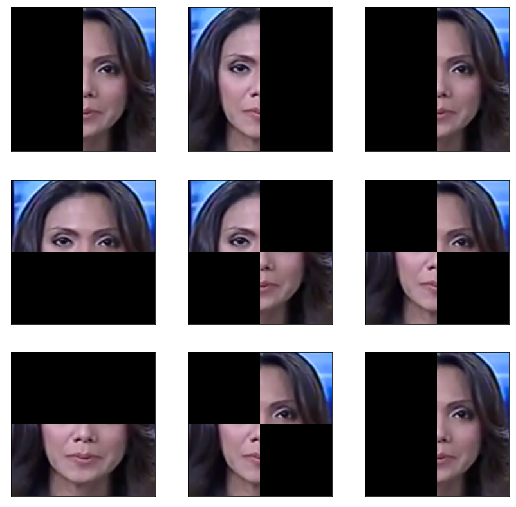

In [8]:
#def alternative_GridMask_augmentation(image, prob, n):
def alternative_GridMask_augmentation(image, prob = 0.5):
    '''Takes inputs of an image and probability

    If augmentation is performed, then the style is chosen randomly -- with
    equal likelihood of 1/6 -- between cutting out top, bottom, left or right
    half or two quarters positioned diagonally (two options)
    
    Returns an (augmented with probability prob) image in the form of array'''

    arr = np.array(image)

    if np.random.uniform(0, 1,1) > prob:
        return arr 
    else:
        n = random.uniform(0, 6)

        if 0 <= n and n <= 1: # cut top half
            arr[:arr.shape[0] // 2,:] = 0
        elif 1 < n and n <= 2: # cut bottom half
            arr[arr.shape[0] // 2 :,:] = 0
        elif 2 < n and n <= 3: # cut right half
            arr[:,arr.shape[1] // 2:] = 0
        elif 3 < n and n <= 4: # cut left half
            arr[:,:arr.shape[1] // 2] = 0
        elif 4 < n and n <= 5: # cut top left and bottom right quarters
            arr[:arr.shape[0] // 2 , :arr.shape[1] // 2] = 0
            arr[arr.shape[0] // 2:, arr.shape[0] // 2:] = 0
        elif 5 < n and n <= 6: # cut top right and bottom left quarters
            arr[:arr.shape[0] // 2 , arr.shape[0] // 2:] = 0
            arr[arr.shape[0] // 2:, :arr.shape[0] // 2] = 0

        return arr

def display_images_alternative_GridMask(image, x, size):
    fig, axe = plt.subplots(x, x, figsize=(size, size))
    for i in range(x):
        for j in range(x):
            augmented = alternative_GridMask_augmentation(image, 1.0)
            axe[i][j].imshow(augmented, interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()

display_images_alternative_GridMask(test_img, 3, 9)

## Image for Report

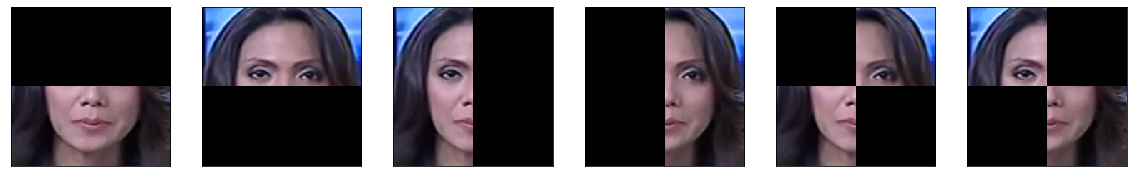

In [7]:
# FIGURE FOR THE REPORT TO ILLUSTRATE ALTERNATIVE GRIDMASK AUGMENTATION
# note: function above was modified to have an extra input of n,
# ensuring that every type of augmentation is illustrated

fig, axe = plt.subplots(1, 6, figsize = (20, 20*6))
aug_0 = alternative_GridMask_augmentation(test_img, 1.0, 0)
aug_1 = alternative_GridMask_augmentation(test_img, 1.0, 2)
aug_2 = alternative_GridMask_augmentation(test_img, 1.0, 3)
aug_3 = alternative_GridMask_augmentation(test_img, 1.0, 4)
aug_4 = alternative_GridMask_augmentation(test_img, 1.0, 5)
aug_5 = alternative_GridMask_augmentation(test_img, 1.0, 6)

axe[0].imshow(aug_0, interpolation="nearest")
axe[1].imshow(aug_1, interpolation="nearest")
axe[2].imshow(aug_2, interpolation="nearest")
axe[3].imshow(aug_3, interpolation="nearest")
axe[4].imshow(aug_4, interpolation="nearest")
axe[5].imshow(aug_5, interpolation="nearest")

for i in range(6):     
    axe[i].set_xticks([])
    axe[i].set_yticks([])

plt.show()

# FacialArtifacts Augmentation

## Facial Landmarks (illustration and image for report)

Facial landmarks detection is performed using face_recognition module. The output is of dictionary type, where keys are facial features and corresponding values are lists of coordinates.

In [64]:
face_landmarks_list = face_recognition.face_landmarks(test_img)
face_landmarks_dict = face_landmarks_list[0]

print(list(face_landmarks_dict.keys()))

# for key in face_landmarks_dict.keys()
    # print(key + ':')
    # print(face_landmarks_dict[key], '\n')

['chin', 'left_eyebrow', 'right_eyebrow', 'nose_bridge', 'nose_tip', 'left_eye', 'right_eye', 'top_lip', 'bottom_lip']


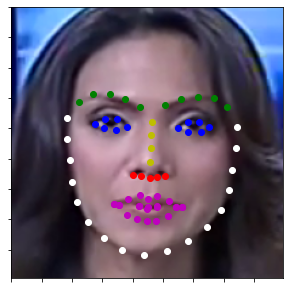

In [65]:
fig, ax = plt.subplots(figsize = (5, 5))
plt.imshow(test_img);
ax.set_xticklabels([])
ax.set_yticklabels([])

colour = ['w', 'g', 'g', 'y', 'r', 'b', 'b', 'm', 'm']

i = 0
for key in list(face_landmarks_dict.keys()):
    for point in face_landmarks_dict[key]:
        x, y = point
        plt.scatter(x, y, color = colour[i])
    i += 1

plt.show()

## Implementation

Cutting out facial artifacts is also inspired by the first-place solution for DFDC and implemented from scratch. The function uses face_recognition module to detect facial landmarks, and crop out rectangles over required region (augmenting with a specified probability.)

The main idea is that cutting out certain regions of the face would force the network to pay attention to the remaining regions, learning better while overfitting less.

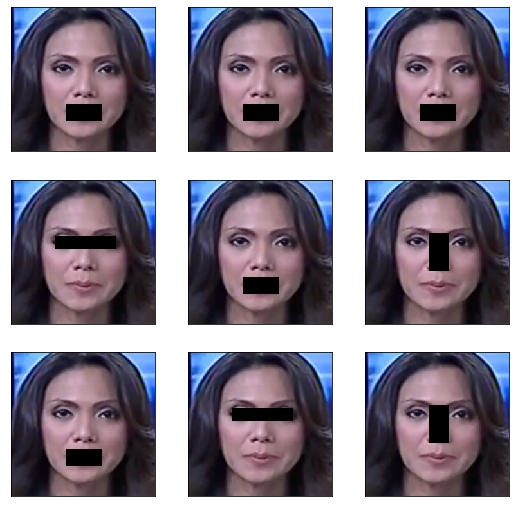

In [79]:
def facial_artifacts_cutout_augmentation(image, prob = 0.5):

    '''Takes in image and a float (probability of augmentation)

    if augments, then relies on face_recognition module and the created
    face_landmarks_dict. A try-except structure is implemented to ensure that
    if augmentation is chosen, but face_recognition did not manage to obtain
    facial landmarks, then the original image in a form of array is returned
    along with a message notifying of the issue.

    Options: cut out mouth, eyes or nose (all equally likely)
    
    Returns a (possibly augmented) image in a form of array'''

    arr = np.array(image)

    if np.random.uniform(0, 1,1) > prob:
        return arr 
    
    else:
        try:
            face_landmarks_list = face_recognition.face_landmarks(image)
            face_landmarks_dict = face_landmarks_list[0]
            n = random.uniform(0, 3)

            if 0 <= n and n <= 1: # cut out mouth
                top_lip = list(face_landmarks_dict['top_lip'])
                bottom_lip = list(face_landmarks_dict['bottom_lip'])

                left_x = top_lip[0][0]
                right_x = top_lip[6][0]
                top_y = (top_lip[2][1] + top_lip[4][1]) //2
                bottom_y = bottom_lip[3][1]
                height = (bottom_y - top_y) * 1.25
                center_y = (top_y + bottom_y) // 2

                arr[int(center_y - height/2):int(center_y + height/2),
                        left_x:right_x] = 0

            elif 1 < n and n <= 2: # cut out nose
                left_eyebrow = list(face_landmarks_dict['left_eyebrow'])[4]
                right_eyebrow = list(face_landmarks_dict['right_eyebrow'])[0]
                nose_tip = list(face_landmarks_dict['nose_tip'])[2]

                width = (right_eyebrow[0] - left_eyebrow[0]) * 1.5
                center_x = (right_eyebrow[0] + left_eyebrow[0]) // 2

                arr[(left_eyebrow[1] + left_eyebrow[1]) //2:nose_tip[1],
                        int(center_x - width/2):int(center_x + width/2)] = 0

            elif 2 < n and n <= 3: # cut out eyes
                left_eye = list(face_landmarks_dict['left_eye'])
                right_eye = list(face_landmarks_dict['right_eye'])

                outer_left  = left_eye[0]
                outer_right = right_eye[3]
                top_left_y = (left_eye[1][1] + left_eye[2][1]) //2
                bottom_left_y = (left_eye[4][1] + left_eye[5][1]) //2

                top_right_y = (right_eye[1][1] + right_eye[2][1]) //2
                bottom_right_y = (right_eye[4][1] + right_eye[5][1]) //2
                
                top_y =  (top_left_y + top_right_y) //2
                bottom_y = (bottom_left_y + bottom_right_y) //2

                center_y = (top_y + bottom_y) // 2
                height = (bottom_y - top_y) * 2.5
                
                arr[int(center_y - height/2):int(center_y + height/2),
                    outer_left[0]:outer_right[0]] = 0
            
            return arr

        except:
          print('issue with face_recognition')
          return arr

def display_images_facial_artifacts(image, x, size):
    fig, axe = plt.subplots(x, x, figsize=(size, size))
    for i in range(x):
        for j in range(x):
            augmented = facial_artifacts_cutout_augmentation(image, 1.0)
            axe[i][j].imshow(augmented, interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()

display_images_facial_artifacts(test_img, 3, 9)

## Image for Report

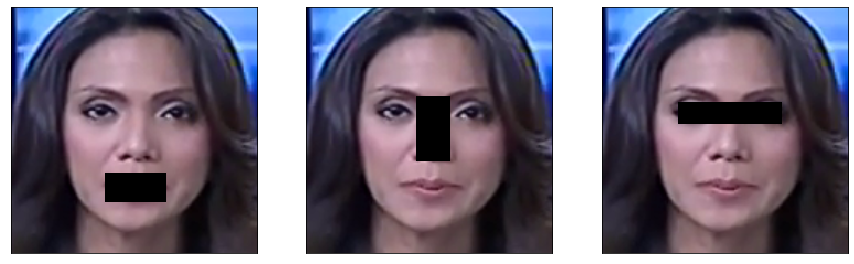

In [78]:
# FIGURE FOR THE REPORT TO ILLUSTRATE FACIAL-ARTIFACTS AUGMENTATION
# note: function above was modified to have an extra input of n,
# ensuring that every type of augmentation is illustrated

fig, axe = plt.subplots(1, 3, figsize = (15, 5))
aug_0 = facial_artifacts_cutout_augmentation(test_img, 1.0, 0)
aug_1 = facial_artifacts_cutout_augmentation(test_img, 1.0, 2)
aug_2 = facial_artifacts_cutout_augmentation(test_img, 1.0, 3)

axe[0].imshow(aug_0, interpolation="nearest")
axe[1].imshow(aug_1, interpolation="nearest")
axe[2].imshow(aug_2, interpolation="nearest")

axe[0].set_yticks([])
axe[1].set_yticks([])
axe[2].set_yticks([])
axe[0].set_xticks([])
axe[1].set_xticks([])
axe[2].set_xticks([])

plt.show()

# FaceMask Augmentation

FaceMask augmentation is implemented relying on face_recognition (to get the landmarks) and face_parser from https://github.com/shaoanlu/face_toolbox_keras. 

The main idea is to cut out left/right/top or bottom half of the face mask for a given image. The cut is determined by the position of the nose: vertical cut is performed along the average x value for nose bridge coordinates, while the horizontal cut is done along the y value for the lowest nose bridge coordinate. The outer perimeter of the face is obtained using the face_parser that outputs a {img_dim}x{img_dim} array (shape is (img_dim, img_dim ,1) where each pixel is an integer based on the region on the image.

The main idea again is prevent overfitting while preserving relevant information; in this case, the regions of interest are, partially, the facial region, and mainly the near-facial region (narrow space right around the face). I supposed that while this augmentation would be suited for facial-expession manipulation methods detection, it would be particularly important for detection of facial-identity manipulations.

## Loading Functions

Face parser and all other related code between #-lines is from https://github.com/shaoanlu/face_toolbox_keras

In [5]:
!pip install keras==2.2.4

The code in the next cell is copy-pasted from two .py files from the github repository for face_toolbox_keras

Upsampling in the inner part is modified (in BiSeNet_keras) and path to weights is modified in the outer layer (face_parser).

In [6]:
# from models.parser import face_parser
###############################################################################################################
import numpy as np
import cv2
from pathlib import Path

#  from .BiSeNet.bisenet import BiSeNet_keras
###############################################################################################################
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def conv_block(x, f, k, s=1, block_name="", layer_id="", use_activ=True):
    if k != 1:
        x = ZeroPadding2D(1)(x)
    x = Conv2D(f, k, strides=s, padding='valid', use_bias=False, name=block_name+".conv"+layer_id)(x)
    x = BatchNormalization(epsilon=1e-5, name=block_name+".bn"+layer_id)(x)
    x = Activation("relu")(x) if use_activ else x
    return x

def res_block_with_downsampling(x, f, block_name="cp.resnet.layerN"):
    skip = Conv2D(f, 1, strides=2, use_bias=False, name=block_name+".0.downsample.0")(x)
    skip = BatchNormalization(epsilon=1e-5, name=block_name+".0.downsample.1")(skip)
    x = conv_block(x, f, 3, s=2, block_name=block_name+".0", layer_id="1")
    x = conv_block(x, f, 3, block_name=block_name+".0", layer_id="2", use_activ=False)
    x = Add()([x, skip])
    x = Activation("relu")(x)
    
    skip = x
    x = conv_block(x, f, 3, block_name=block_name+".1", layer_id="1")
    x = conv_block(x, f, 3, block_name=block_name+".1", layer_id="2", use_activ=False)
    x = Add()([x, skip])
    x = Activation("relu")(x)
    return x

def attention_refinment_block(x, f, block_name="cp.arm16"):
    x = Conv2D(f, 3, padding='same', use_bias=False, name=block_name+".conv.conv")(x)
    x = BatchNormalization(epsilon=1e-5, name=block_name+".conv.bn")(x)
    x = Activation("relu")(x)
    
    attn = GlobalAveragePooling2D()(x)
    attn = Reshape((1,1,f))(attn)
    attn = Conv2D(f, 1, use_bias=False, name=block_name+".conv_atten")(attn)
    attn = BatchNormalization(epsilon=1e-5, name=block_name+".bn_atten")(attn)
    attn = Activation("sigmoid")(attn)
    x = Multiply()([x, attn])
    return x

def feature_fusion_block(x1, x2):
    x = Concatenate()([x1, x2])
    x = conv_block(x, 256, 1, block_name="ffm.convblk", layer_id="")    
    attn = GlobalAveragePooling2D()(x)
    attn = Reshape((1,1,256))(attn)
    attn = Conv2D(64, 1, use_bias=False, name="ffm.conv1")(attn)
    attn = Activation("relu")(attn)
    attn = Conv2D(256, 1, use_bias=False, name="ffm.conv2")(attn)
    feat_attn = Activation("sigmoid")(attn)
    attn = Multiply()([x, feat_attn])    
    x = Add()([x, attn])
    return x

def upsampling(x, shape, interpolation="nearest"):    
    return Lambda(lambda t: tf.image.resize(t, shape))(x)
    #if interpolation == "nearest":
        # return Lambda(lambda t: tf.image.resize_nearest_neighbor(t, shape, align_corners=True))(x)
        #return Lambda(lambda t: tf.image.resize(t, shape))(x)
    #elif interpolation == "bilinear":
        #return Lambda(lambda t: tf.image.resize_bilinear(t, shape, align_corners=True))(x)

def maxpool(x, k=3, s=2, pad=1):
    x = ZeroPadding2D(pad)(x)
    x = MaxPooling2D((k,k), strides=s)(x)
    return x
    
def BiSeNet_keras(input_resolution=512):
    inp = Input((input_resolution, input_resolution, 3))
    x = ZeroPadding2D(3)(inp)
    x = Conv2D(64, 7, strides=2, use_bias=False, name="cp.resnet.conv1")(x)
    x = BatchNormalization(epsilon=1e-5, name="cp.resnet.bn1")(x)
    x = Activation('relu')(x)
    x = maxpool(x)
    
    # layer1
    skip = x
    x = conv_block(x, 64, 3, block_name="cp.resnet.layer1.0", layer_id="1")
    x = conv_block(x, 64, 3, block_name="cp.resnet.layer1.0", layer_id="2", use_activ=False)
    x = Add()([x, skip])
    x = Activation("relu")(x)
    skip = x
    x = conv_block(x, 64, 3, block_name="cp.resnet.layer1.1", layer_id="1")
    x = conv_block(x, 64, 3, block_name="cp.resnet.layer1.1", layer_id="2", use_activ=False)
    x = Add()([x, skip])
    x = Activation("relu")(x)
    
    # layer2
    x = res_block_with_downsampling(x, 128, block_name="cp.resnet.layer2")
    feat8 = x
    
    # layer3
    x = res_block_with_downsampling(x, 256, block_name="cp.resnet.layer3")
    feat16 = x
    
    # ARM1
    feat16_arm = attention_refinment_block(feat16, 128, block_name="cp.arm16")
    
    # layer4
    x = res_block_with_downsampling(x, 512, block_name="cp.resnet.layer4")   
    feat32 = x 
    
    # ARM2 and conv_avg
    conv_avg = GlobalAveragePooling2D()(x)
    conv_avg = Reshape((1,1,512))(conv_avg)
    conv_avg = conv_block(conv_avg, 128, 1, block_name="cp.conv_avg", layer_id="")
    avg_up = upsampling(conv_avg, [input_resolution//32, input_resolution//32])
    feat32_arm = attention_refinment_block(x, 128, block_name="cp.arm32")
    feat32_sum = Add(name="feat32_sum")([feat32_arm, avg_up])
    feat32_up = upsampling(feat32_sum, [input_resolution//16, input_resolution//16])
    feat32_up = conv_block(feat32_up, 128, 3, block_name="cp.conv_head32", layer_id="")
    
    feat16_sum = Add(name="feat16_sum")([feat16_arm, feat32_up])
    feat16_up = upsampling(feat16_sum, [input_resolution//8, input_resolution//8])
    feat16_up = conv_block(feat16_up, 128, 3, block_name="cp.conv_head16", layer_id="")
    
    # FFM
    feat_sp, feat_cp8 = feat8, feat16_up
    feat_fuse = feature_fusion_block(feat_sp, feat_cp8)
    
    feat_out = conv_block(feat_fuse, 256, 3, block_name="conv_out.conv", layer_id="")
    feat_out = Conv2D(19, 1, strides=1, use_bias=False, name="conv_out.conv_out")(feat_out)
    feat_out = upsampling(feat_out, [input_resolution, input_resolution], interpolation="bilinear")
    # Ignore feat_out32 and feat_out16 since they are not used in inference phase
    
    return Model(inp, feat_out)
###############################################################################################################

class FaceParser():
    def __init__(self, path_bisenet_weights="drive/My Drive/BiSeNet_keras.h5", detector=None):
        self.parser_net = None
        self.detector = detector
    
        self.build_parser_net(path_bisenet_weights)
        
    def build_parser_net(self, path):
        parser_net = BiSeNet_keras()
        parser_net.load_weights(path)
        self.parser_net = parser_net
        
    def set_detector(self, detector):
        self.detector = detector
    
    def remove_detector(self):
        self.detector = None
    
    def parse_face(self, im, bounding_box=None, with_detection=False):
        orig_h, orig_w = im.shape[:2]
        
        # Detect/Crop face RoI
        if bounding_box == None:
            if with_detection:
                try:
                    self.detector.fd
                except:
                    raise NameError("Error occurs during face detection: \
                    detector not found in FaceParser.")
                bboxes = self.detector.fd.detect_face(im)
                faces = []
                for bbox in bboxes:
                    y0, x0, y1, x1, _ = bbox
                    x0, y0 = np.maximum(x0, 0), np.maximum(y0, 0)
                    x1, y1 = np.minimum(x1, orig_h), np.minimum(y1, orig_w)
                    x0, y0, x1, y1 = map(np.int32, [x0, y0, x1, y1])
                    faces.append(im[x0:x1, y0:y1, :])
            else:
                faces = [im]
        else:
            x0, y0, x1, y1 = bounding_box
            x0, y0 = np.maximum(x0, 0), np.maximum(y0, 0)
            x1, y1 = np.minimum(x1, orig_h), np.minimum(y1, orig_w)
            x0, y0, x1, y1 = map(np.int32, [x0, y0, x1, y1])
            faces = [im[x0:x1, y0:y1, :]]
        
        maps = []
        for face in faces:
            # Preprocess input face for parser networks
            orig_h, orig_w = face.shape[:2]
            inp = cv2.resize(face, (512,512))
            inp = self.normalize_input(inp)
            inp = inp[None, ...]

            # Parser networks forward pass
            # Do NOT use bilinear interp. which adds artifacts to the parsing map
            out = self.parser_net.predict([inp])[0]
            parsing_map = out.argmax(axis=-1)
            parsing_map = cv2.resize(
                parsing_map.astype(np.uint8), 
                (orig_w, orig_h), 
                interpolation=cv2.INTER_NEAREST)
            maps.append(parsing_map)
        return maps
        
    @staticmethod
    def normalize_input(x, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        # x should be RGB with range [0, 255]
        return ((x / 255) - mean)  / std
###############################################################################################################

Next cell is taken from visualize.py from face_toolbox_keras github repository also

In [7]:
# from utils.visualize import show_parsing_with_annos
###############################################################################################################
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

parsing_annos = [
    '0, background', '1, skin', '2, left eyebrow', '3, right eyebrow', 
    '4, left eye', '5, right eye', '6, glasses', '7, left ear', '8, right ear', '9, earings',
    '10, nose', '11, mouth', '12, upper lip', '13, lower lip', 
    '14, neck', '15, neck_l', '16, cloth', '17, hair', '18, hat'
]

# https://matplotlib.org/tutorials/colors/colormap-manipulation.html
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
def show_parsing_with_annos(data):
    fig, ax = plt.subplots(figsize=(8,8))
    #get discrete colormap
    cmap = plt.get_cmap('gist_ncar', len(parsing_annos))
    new_colors = cmap(np.linspace(0, 1, len(parsing_annos)))
    new_colors[0, :] = np.array([0, 0, 0, 1.])
    new_cmap = ListedColormap(new_colors)
    
    # set limits .5 outside true range
    mat = ax.matshow(data, cmap=new_cmap, vmin=-0.5, vmax=18.5)
    
    #tell the colorbar to tick at integers    
    cbar = fig.colorbar(mat, ticks=np.arange(0, len(parsing_annos)))
    cbar.ax.set_yticklabels(parsing_annos)
    plt.axis('off')
    fig.show()
###############################################################################################################

## Example (and image for report)

Parsing map contains one element per face. Each of these elements is a multidimensional array (shape is img_height, img_width, 1) where each integer prepresents a pixel colour-coded based on the object (in range(0, 19)).

These details are shown below for your reference.

In [82]:
# prs = face_parser.FaceParser()
prs = FaceParser()

In [52]:
parsing_map = prs.parse_face(test_img, bounding_box=None, with_detection=False)

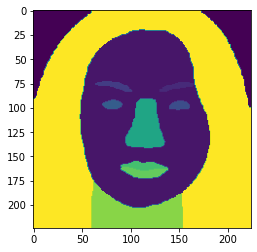

In [84]:
plt.imshow(parsing_map[0]);

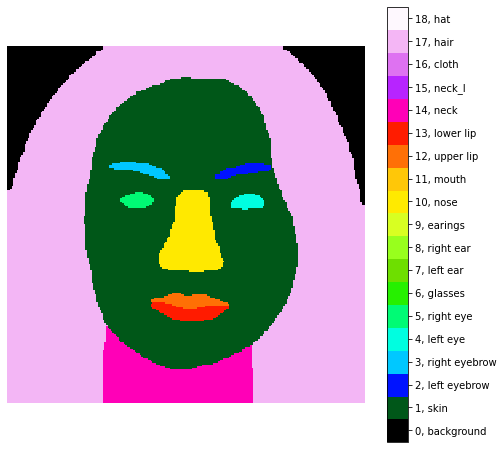

In [87]:
show_parsing_with_annos(parsing_map[0]);

In [88]:
print(type(parsing_map))
print(len(parsing_map))
print(len(parsing_map[0]))
print(len(parsing_map[0][0]))
print(parsing_map[0][0])

<class 'list'>
1
224
224
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


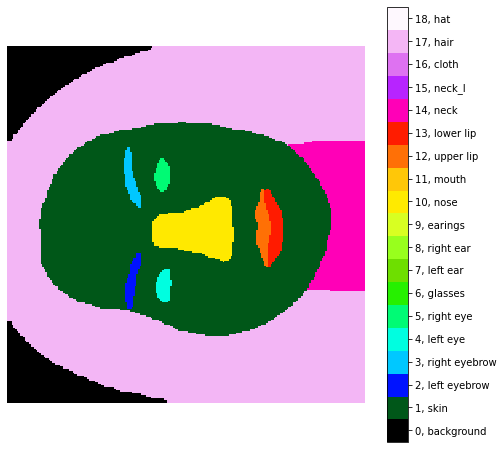

In [54]:
# transpose illustration for facial-artifacts-alternative augmentation
parsing_map_transposed = parsing_map[0].T
show_parsing_with_annos(parsing_map_transposed);

# to flip it back with one more transpose opearation

## Implementation

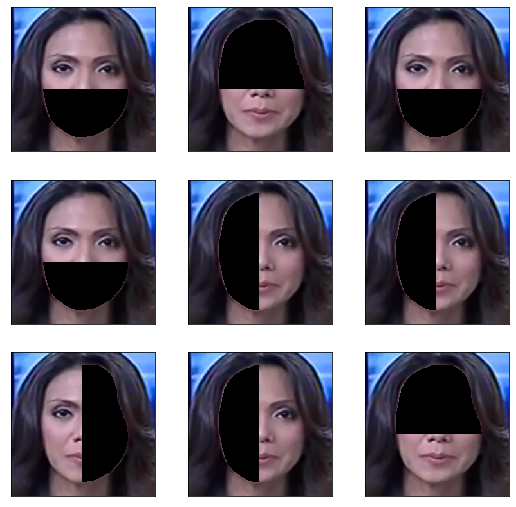

In [12]:
def facial_mask_cutout_augmentation(image, prob = 0.5):

    '''Takes in image and a float (probability of augmentation)

    if augments, then relies on face_recognition module and the FaceParser class. 
    A try-except structure is implemented to ensure that if augmentation is
    chosen, but face_recognition did not manage to obtain facial landmarks or
    face_parser did not detect a face to analyse, then the original image in a
    form of array is returned along with a message notifying of the issue.

    Options: cut out left/right/top or bottom halves of the facial region
    (all equally likely)
    
    Returns a (possibly augmented) image in a form of array'''

    arr = np.array(image)

    if np.random.uniform(0, 1, 1) > prob:
        return arr 
    
    else:
        try:
            # note: currently an instace of FaceParser class is not created at every
            # augmentation (might create a time bottleneck) and is performed separately
            parsing_map = prs.parse_face(image, bounding_box=None, with_detection=False)

            face_landmarks_list = face_recognition.face_landmarks(image)
            face_landmarks_dict = face_landmarks_list[0]
            n = random.uniform(0, 4)

            if n <= 2: # cut vertically
                # nose_tip = list(face_landmarks_dict['nose_tip'])[2][1]
                nose_tip = list(face_landmarks_dict['nose_bridge'])[3][1]
                start_j = 0; end_j = arr.shape[1]
                # cut top half
                if n <= 1: start_i = 0; end_i = nose_tip
                # cut bottom half
                elif n > 1: start_i = nose_tip; end_i = arr.shape[0]

            elif n > 2: # cut horizontally
                nose_bridge = list(face_landmarks_dict['nose_bridge'])
                avg_y = int(sum([el[1] for el in nose_bridge])/ len(nose_bridge))
                start_i = 0; end_i = arr.shape[0]
                # cut left half
                if n <= 3: start_j = 0; end_j = avg_y
                # cut right half
                elif n > 3: start_j = avg_y; end_j = arr.shape[1]

            for i in range(start_i, end_i):
                for j in range(start_j, end_j):
                    # parsing_map[face][y][x]
                    pixel = parsing_map[0][i][j]
                    if pixel in list(range(1,14)):
                        arr[i][j] = [0, 0, 0]
            
            return arr

        except:
            print('issue with face_recognition or face_parser')
            return arr

def display_images_facial_mask(image, x, size):
    fig, axe = plt.subplots(x, x, figsize=(size, size))
    for i in range(x):
        for j in range(x):
            augmented = facial_mask_cutout_augmentation(image, 1.0)
            axe[i][j].imshow(augmented, interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()


prs = FaceParser()
display_images_facial_mask(test_img, 3, 9)

## Image for Report

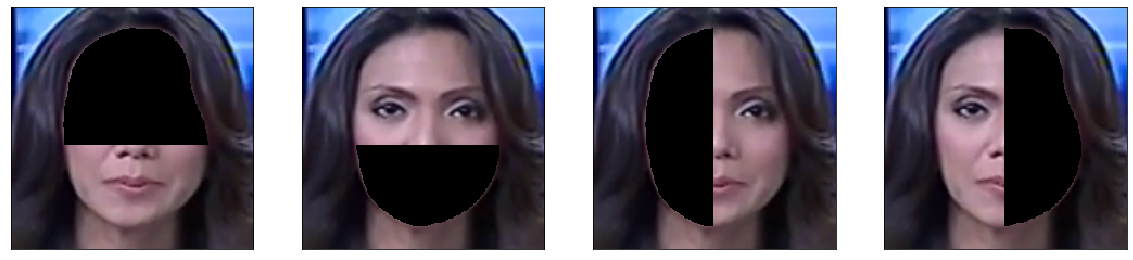

In [11]:
# FIGURE FOR THE REPORT TO ILLUSTRATE FACIAL-MASK AUGMENTATION
# note: function above was modified to have an extra input of n,
# ensuring that every type of augmentation is illustrated

prs = FaceParser()

fig, axe = plt.subplots(1, 4, figsize = (20, 5))
aug_0 = facial_mask_cutout_augmentation(test_img, 1.0, 0)
aug_1 = facial_mask_cutout_augmentation(test_img, 1.0, 2)
aug_2 = facial_mask_cutout_augmentation(test_img, 1.0, 3)
aug_3 = facial_mask_cutout_augmentation(test_img, 1.0, 4)

axe[0].imshow(aug_0, interpolation="nearest")
axe[1].imshow(aug_1, interpolation="nearest")
axe[2].imshow(aug_2, interpolation="nearest")
axe[3].imshow(aug_3, interpolation="nearest")

axe[0].set_yticks([])
axe[1].set_yticks([])
axe[2].set_yticks([])
axe[3].set_yticks([])
axe[0].set_xticks([])
axe[1].set_xticks([])
axe[2].set_xticks([])
axe[3].set_xticks([])

plt.show()

# Facial-Artifacts-Alternative Augmentation

This method is a refined version of facial-artifacts augmentatio (also cuts out three facial artifacts -- nose, mouth or eyes) which a speficied probablity. The main advantage is that the regions are of varying shape which matches the cut out feautres much more closely than the rectangles utilised in the previous version; this might provide us with an advantage when detecting facial-expression manipulation methods since the important regions around the swaped facial feautres are still visible.

Unlike the previous version, facial-artifacts-alternative does not utilise face_recognition module and perfroms augmentation relying on the FaceParser class instead.

Note: here parsing_map is transposed twice and modified to make regions convex. While this is necessary for the eyes in simpler form (to fill in the gaps between left and right eye), it can be omitted to some extent if too computationally expensive and long.

## Implementation

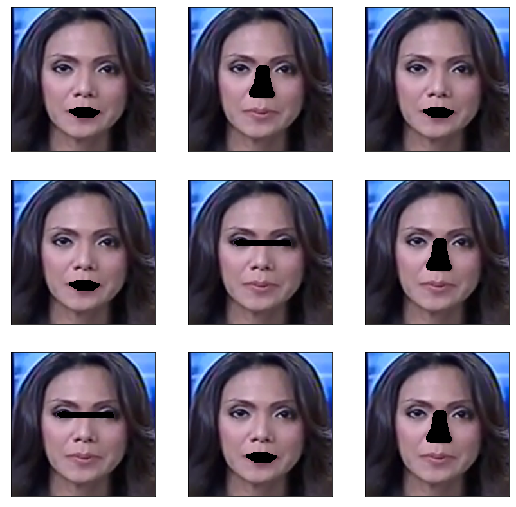

In [66]:
def alternative_facial_artifacts_cutout_augmentation(image, prob = 0.5):

    '''A refined version of facial_artifacts_cutout_augmentation (cutting
    out regions which are convex in x and y -- meaning there are no gaps in
    cutout region's rows or columns)
    
    Takes in image and a float (probability of augmentation)

    if augments, then relies on the FaceParser class. 
    A try-except structure is implemented to ensure that if augmentation is
    chosen, but face_recognition did not manage to obtain facial landmarks or
    face_parser did not detect a face to analyse, then the original image in a
    form of array is returned along with a message notifying of the issue.

    Options: cut out mouth, eyes or nose (all equally likely)
    
    Returns a (possibly augmented) image in a form of array'''

    arr = np.array(image)

    if np.random.uniform(0, 1, 1) > prob:
        return arr 
    
    else:
        try:
            # note: currently an instace of FaceParser class is not created at every
            # augmentation (might create a time bottleneck) and is performed separately
            parsing_map = prs.parse_face(image, bounding_box=None, with_detection=False)

            n = random.uniform(0, 3)

            def fill_in_gaps(a, left_eye, right_eye):
                '''Takes in a one-dimensional list and two integers (which represent 
                left and right eyes in the parsing map)
                
                Checks if there are such elements, if so, pick the outer positions 
                and fill the space in between with the left_eye integer
                
                Returns an old (if both elements are not present) or newly 
                filled-in list'''
                
                left_eye_indices = [i for i, x in enumerate(a) if x == left_eye]
                right_eye_indices = [i for i, x in enumerate(a) if x == right_eye]
                if len(left_eye_indices) < 1 or len(right_eye_indices) < 1:
                    return a
                    
                else:
                    new_a = a[:]
                    left_x = min(left_eye_indices)
                    right_x = max(right_eye_indices)
                    change_indices = list(range(left_x, right_x + 1))
                    for i in change_indices: new_a[i] = left_eye
                    return new_a

            if 0 <= n and n <= 1: # cut out mouth
                regions = [11, 12, 13]; left_edge = regions; right_edge = regions

            elif 1 < n and n <= 2: # cut out eyes
                regions = [4, 5, 6]; left_edge = [5, 6]; right_edge = [4, 6]

            elif 2 < n and n <= 3: # cut out nose
                regions = [10]; left_edge = regions; right_edge = regions

            parsing_map_t = parsing_map[0].T
            for i in range(image.shape[0]):
                for k in regions:
                    parsing_map_t[i] = fill_in_gaps(parsing_map_t[i], k, k)
            parsing_map[0] = parsing_map_t.T
              
            for i in range(image.shape[0]):
                for k in range(len(left_edge)):
                    parsing_map[0][i] = fill_in_gaps(parsing_map[0][i],
                                                     left_edge[k], right_edge[k])
                for j in range(image.shape[1]):
                    # parsing_map[face][y][x]
                    pixel = parsing_map[0][i][j]
                    if pixel in regions:
                        arr[i][j] = [0, 0, 0] 
            return arr

        except:
            print('issue with face_parser')
            return arr

def display_images_alternative_facial_artifacts(image, x, size):
    fig, axe = plt.subplots(x, x, figsize=(size, size))
    for i in range(x):
        for j in range(x):
            augmented = alternative_facial_artifacts_cutout_augmentation(image, 1.0)
            axe[i][j].imshow(augmented, interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()

prs = FaceParser()
display_images_alternative_facial_artifacts(test_img, 3, 9)

## Image for Report

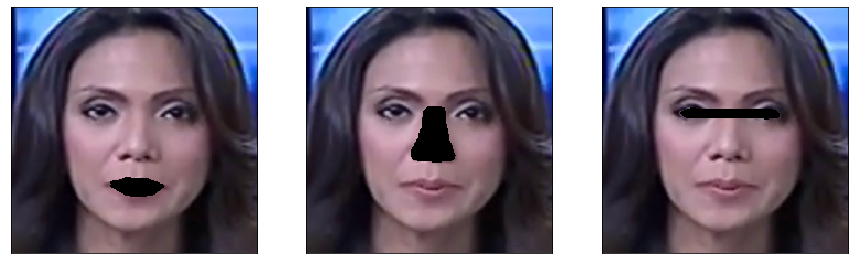

In [65]:
# FIGURE FOR THE REPORT TO ILLUSTRATE FACIAL-ARTIFACTS-ALTERNATIVE AUGMENTATION
# note: function above was modified to have an extra input of n,
# ensuring that every type of augmentation is illustrated

fig, axe = plt.subplots(1, 3, figsize = (15, 5))
aug_0 = alternative_facial_artifacts_cutout_augmentation(test_img, 1.0, 0)
aug_1 = alternative_facial_artifacts_cutout_augmentation(test_img, 1.0, 3)
aug_2 = alternative_facial_artifacts_cutout_augmentation(test_img, 1.0, 2)

axe[0].imshow(aug_0, interpolation="nearest")
axe[1].imshow(aug_1, interpolation="nearest")
axe[2].imshow(aug_2, interpolation="nearest")

axe[0].set_yticks([])
axe[1].set_yticks([])
axe[2].set_yticks([])
axe[0].set_xticks([])
axe[1].set_xticks([])
axe[2].set_xticks([])

plt.show()